In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance

In [79]:
#extract processed data
df = pd.read_csv("processed_data.csv")

#remove extreme high correlation varaibles and unrelated variables 
df.drop(['ANNMILES', 'GASUSGE', ], axis=1, inplace=True)

#separate prediction variable and id from dataframe
df_y = df.pop('SuperUser')
id = df.pop("HOUSEID")

#create train and test dataset
x_train, x_test, y_train, y_test = train_test_split(df, df_y, test_size=0.2)

#(df.columns)

In [80]:
y_train.value_counts()

SuperUser
0    5147
1     585
Name: count, dtype: int64

In [81]:
print(y_train.value_counts())

SuperUser
0    5147
1     585
Name: count, dtype: int64


In [82]:
x = pd.concat([x_train, y_train], axis=1)
non_superuser = x[x.SuperUser == 0]
superuser = x[x.SuperUser == 1]
superuser_upsampled = resample(superuser, replace=True, n_samples = len(non_superuser), random_state=42)
upsampled = pd.concat([non_superuser,superuser_upsampled])
up_y_train = upsampled.SuperUser
up_x_train = upsampled.drop('SuperUser', axis=1)
up_y_train.value_counts()


SuperUser
0    5147
1    5147
Name: count, dtype: int64

In [83]:
non_superuser_downsampled = resample(non_superuser, replace = False, n_samples = len(superuser), random_state=42)
downsampled = pd.concat([non_superuser_downsampled, superuser])
d_y_train = downsampled.SuperUser
d_x_train = downsampled.drop('SuperUser', axis=1)
d_y_train.value_counts()

SuperUser
0    585
1    585
Name: count, dtype: int64

Due to data being imbalanced in nonsuperuser vs superuser, KNN is not suited

In [84]:
knn = KNeighborsClassifier(n_neighbors=5)
#knn.fit(x_train, y_train)
#knn.fit(up_x_train, up_y_train)
knn.fit(d_x_train, d_y_train)

y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print('Confusion matrix')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))


Accuracy: 62.62%
ROCAUC: 59.33%
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.63      0.75      1302
           1       0.13      0.55      0.21       132

    accuracy                           0.63      1434
   macro avg       0.53      0.59      0.48      1434
weighted avg       0.86      0.63      0.71      1434

Confusion matrix
     0    1
0  825  477
1   59   73


In [85]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=25, min_samples_leaf=25, min_samples_split = 25,
                             max_features= 'sqrt',
                             class_weight={0:0.1, 1:0.9},
                             #class_weight = 'balanced'
                            )

x, y = x_train, y_train
#x, y = up_x_train, up_y_train
#x, y = d_x_train, d_y_train

y = y.reset_index(drop=True)
x = x.reset_index(drop=True)

rfc.fit(x, y)
test_pred = rfc.predict(x)

print("Train data accuracy report:")
accuracy = accuracy_score(y, test_pred)
roc_score = roc_auc_score(y, test_pred)
class_report = classification_report(y, test_pred)
#print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print(pd.DataFrame(confusion_matrix(y, test_pred)), '\n')



Train data accuracy report:
ROCAUC: 77.90%
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89      5147
           1       0.33      0.73      0.45       585

    accuracy                           0.82      5732
   macro avg       0.65      0.78      0.67      5732
weighted avg       0.90      0.82      0.85      5732

      0    1
0  4280  867
1   160  425 



In [86]:
y_pred = rfc.predict(x_test)

print("Test data accuracy report:")
accuracy = accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
#print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print()
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print()

Test data accuracy report:
ROCAUC: 65.02%
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87      1302
           1       0.21      0.49      0.29       132

    accuracy                           0.78      1434
   macro avg       0.57      0.65      0.58      1434
weighted avg       0.87      0.78      0.82      1434


      0    1
0  1052  250
1    67   65



In [87]:
plt.figure(figsize=(15,20), dpi=1000)
plot_tree(rfc.estimators_[0], 
          feature_names=df.columns[:-1],
          class_names=[str(c) for c in df_y.unique()],
          filled= True
          )


[Text(0.5985838779956427, 0.9666666666666667, 'HHSIZE <= 0.135\ngini = 0.5\nsamples = 3596\nvalue = [517.7, 499.5]\nclass = 0'),
 Text(0.3660130718954248, 0.9, 'HighestEDUC <= 5.5\ngini = 0.483\nsamples = 2512\nvalue = [370.7, 255.6]\nclass = 0'),
 Text(0.14896514161220042, 0.8333333333333334, 'MCTRANSIT <= 1.406\ngini = 0.496\nsamples = 1027\nvalue = [148.6, 124.2]\nclass = 0'),
 Text(0.14025054466230938, 0.7666666666666667, 'WTHHFIN <= -0.401\ngini = 0.492\nsamples = 1000\nvalue = [144.9, 111.6]\nclass = 0'),
 Text(0.08278867102396514, 0.7, 'HHFAMINC_IMP <= 7.5\ngini = 0.405\nsamples = 304\nvalue = [45.8, 18.0]\nclass = 0'),
 Text(0.07407407407407407, 0.6333333333333333, 'WTHHFIN5D <= -0.291\ngini = 0.433\nsamples = 262\nvalue = [38.8, 18.0]\nclass = 0'),
 Text(0.05228758169934641, 0.5666666666666667, 'WTHHFIN <= -0.59\ngini = 0.479\nsamples = 190\nvalue = [27.3, 18.0]\nclass = 0'),
 Text(0.034858387799564274, 0.5, 'WTHHFIN <= -0.635\ngini = 0.497\nsamples = 124\nvalue = [17.0, 14.4]

In [88]:
"""
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import regularizers

model = Sequential()
model.add(Dense(128, input_dim=x.shape[1], activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(64, input_dim=x.shape[1], activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(36, input_dim=x.shape[1], activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_crossentropy'])

a_weight = y.value_counts()[1]/y.value_counts()[0]
b_weight = 1-y.value_counts()[1]/y.value_counts()[0]

history = model.fit(x,y, class_weight={0:a_weight, 1:b_weight}, epochs=10, verbose=1)

rfc.fit(x, y)
print("Train data accuracy report:")
accuracy = accuracy_score(y, test_pred)
roc_score = roc_auc_score(y, test_pred)
class_report = classification_report(y, test_pred)
#print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print(pd.DataFrame(confusion_matrix(y, test_pred)), '\n')
"""


'\nfrom keras.layers import Dense, Dropout\nfrom keras.models import Sequential\nfrom keras import regularizers\n\nmodel = Sequential()\nmodel.add(Dense(128, input_dim=x.shape[1], activation = \'relu\', kernel_regularizer=regularizers.l2(0.0001)))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(64, input_dim=x.shape[1], activation = \'relu\', kernel_regularizer=regularizers.l2(0.0001)))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(36, input_dim=x.shape[1], activation = \'relu\', kernel_regularizer=regularizers.l2(0.0001)))\nmodel.add(Dropout(0.2))\nmodel.add(Dense(1, activation=\'sigmoid\'))\nmodel.compile(loss=\'binary_crossentropy\', optimizer=\'sgd\', metrics=[\'binary_crossentropy\'])\n\na_weight = y.value_counts()[1]/y.value_counts()[0]\nb_weight = 1-y.value_counts()[1]/y.value_counts()[0]\n\nhistory = model.fit(x,y, class_weight={0:a_weight, 1:b_weight}, epochs=10, verbose=1)\n\nrfc.fit(x, y)\nprint("Train data accuracy report:")\naccuracy = accuracy_score(y, test_pred)\nroc_score = roc_a

In [89]:
"""
y_pred = model.predict(x_test)
y_pred = np.array([1 if x>=0.5 else 0 for x in y_pred])
accuracy = accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
#print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print()
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print()
"""

'\ny_pred = model.predict(x_test)\ny_pred = np.array([1 if x>=0.5 else 0 for x in y_pred])\naccuracy = accuracy_score(y_test, y_pred)\nroc_score = roc_auc_score(y_test, y_pred)\nclass_report = classification_report(y_test, y_pred)\n#print(f"Accuracy: {accuracy * 100:.2f}%")\nprint(f"ROCAUC: {roc_score * 100:.2f}%")\nprint("Classification Report:\n", class_report)\nprint()\nprint(pd.DataFrame(confusion_matrix(y_test, y_pred)))\nprint()\n'

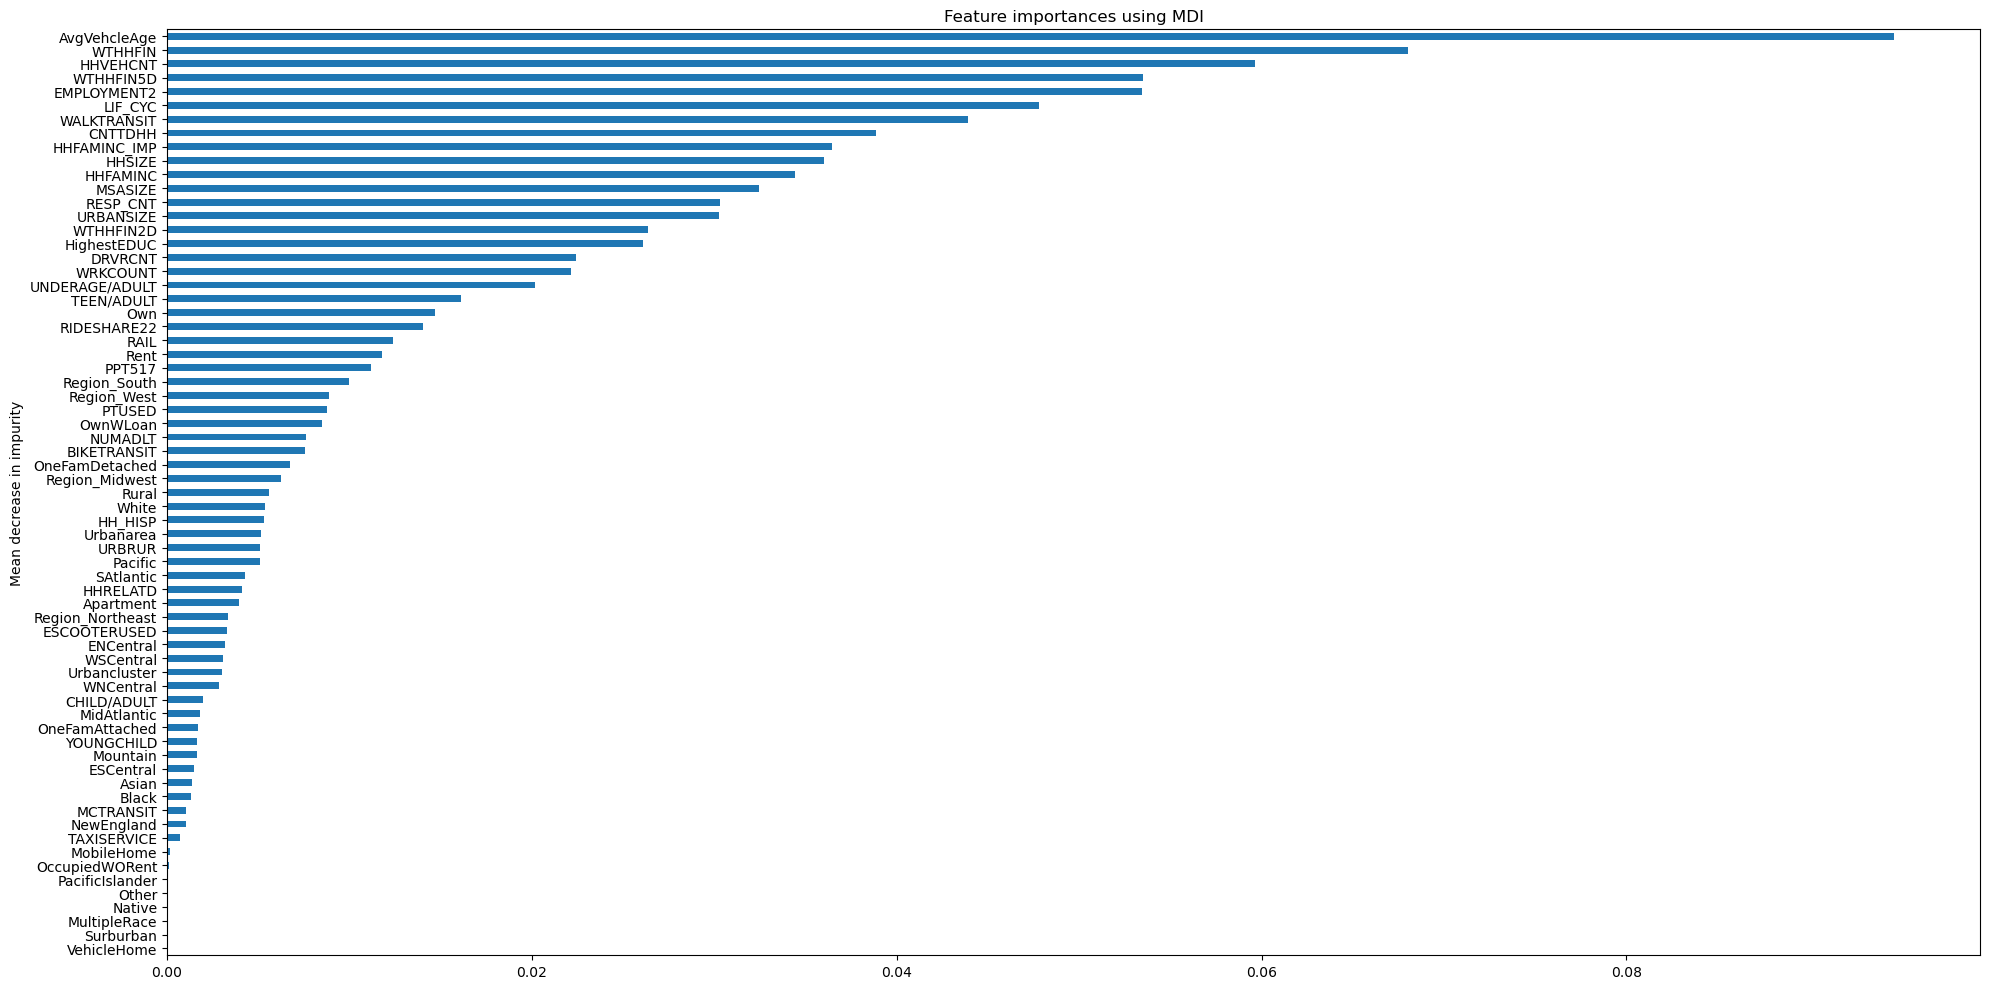

In [90]:
importances = pd.Series(rfc.feature_importances_, index=rfc.feature_names_in_).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(20,10))
ax = importances.plot.barh()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [91]:
result = permutation_importance(
    rfc, x_test, y_test, n_repeats=10, random_state=None, n_jobs=4
)

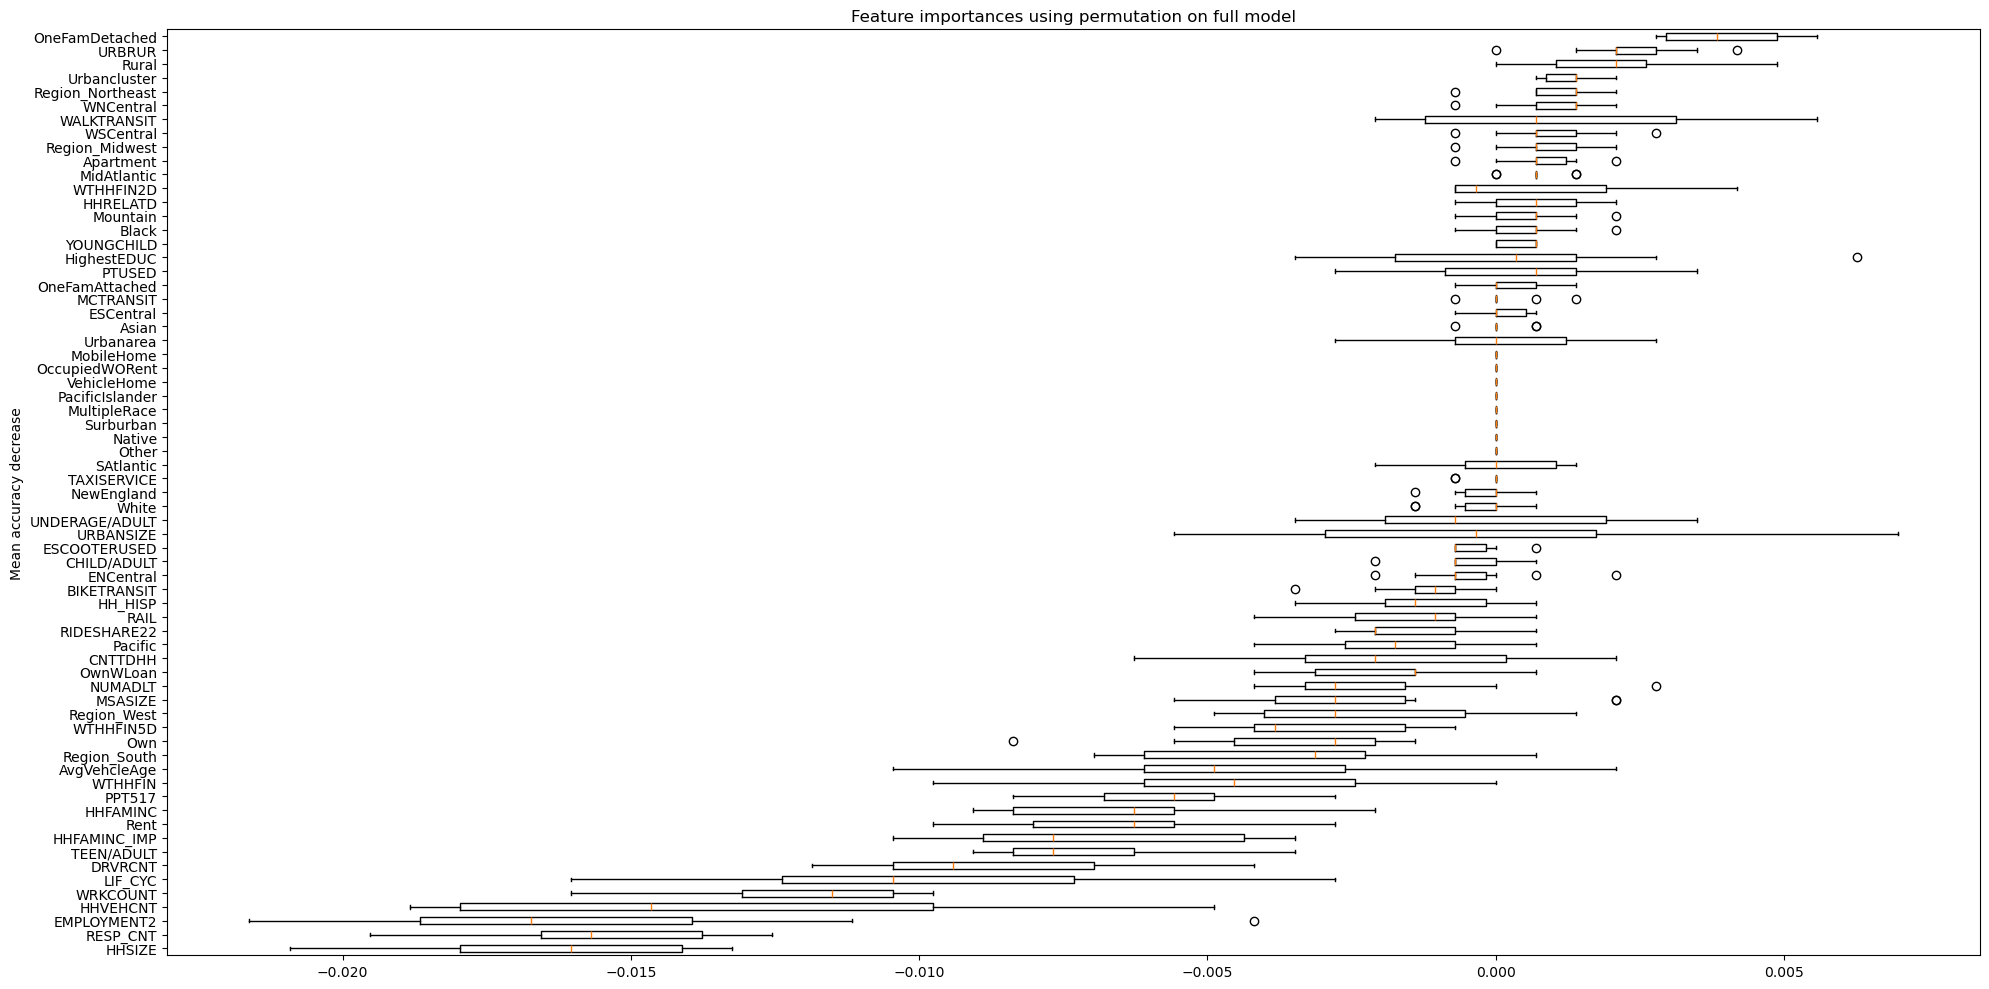

In [92]:
sorted_importances_idx = result.importances_mean.argsort()
#forest_importances = pd.Series(result.importances_mean, index=rfc.feature_names_in_)
forest_importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=x_test.columns[sorted_importances_idx],
)

fig, ax = plt.subplots(figsize=(20,10))
ax.boxplot(result.importances[sorted_importances_idx].T,
           vert=False,
           labels=x_test.columns[sorted_importances_idx]
           )
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()